In [1]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
w = np.array([0.299, 0.587, 0.114])

def count_energy(img_gs):
    h_grad = np.zeros_like(img_gs)
    h_grad[1:-1] = img_gs[2:] - img_gs[:-2]
    h_grad[0] = img_gs[1] - img_gs[0]
    h_grad[-1] = img_gs[-1] - img_gs[-2]
    
    v_grad = np.zeros_like(img_gs)
    v_grad[:, 1:-1] = img_gs[:, 2:] - img_gs[:, :-2]
    v_grad[:, 0] = img_gs[:, 1] - img_gs[:, 0]
    v_grad[:, -1] = img_gs[:, -1] - img_gs[:, -2]
    
    return np.sqrt(h_grad ** 2 + v_grad ** 2)

def count_seam(img_energy, MAX_ENERGY):
    seam = np.copy(img_energy)
    layers = MAX_ENERGY * np.ones((img_energy.shape[1] + 2, 3))
    for i, energy in enumerate(seam[:-1]):
        layers[:-2, 0] = np.copy(energy)
        layers[1:-1, 1] = np.copy(energy)
        layers[2:, 2] = np.copy(energy)
    
        min_energy = np.min(layers[1:-1], axis=1)
        seam[i + 1] += min_energy
        
    return seam

def get_min_seam(img_seam):
    seam = np.zeros(img_seam.shape[0], dtype=np.int)
    armin = np.argmin(img_seam[-1])
    for i in range(img_seam.shape[0] - 1, -1, -1):
        if armin > 0:
            tmp = np.argmin(img_seam[i, armin - 1: armin + 2]) - 1
        else:
            tmp = np.argmin(img_seam[i, :2])
        armin += tmp
        seam[i] = armin
    
    return seam

In [4]:
def seam_carve_nomask(img, mode, mask=None):
    MAX_ENERGY = 256 * img.shape[0] * img.shape[1]
    mode, action = mode.split(' ')
    resize = -1  # 1 if action == 'expand' else -1
    if mode == 'vertical':
        img = img.transpose(1, 0, 2)
        if mask is not None:
            mask = mask.T

    resized_img = np.zeros((img.shape[0], img.shape[1] + resize, 3))
    carve_mask = np.zeros(img.shape[:2])
    if mask is None:
        resized_mask = None
    else:
        resized_mask = np.zeros((img.shape[0], img.shape[1] + resize))

    img_gray = img.dot(w)
    img_energy = count_energy(img_gray)
    if mask is not None:
        img_energy += MAX_ENERGY * mask
    img_seam = count_seam(img_energy, MAX_ENERGY)

    for i, j in enumerate(get_min_seam(img_seam)):
        carve_mask[i, j] = 1
        if resize == -1:
            resized_img[i] = np.delete(img[i], j, axis=0)
        else:
            resized_img[i] = np.insert(img[i], j + 1, axis=0)
        
        if resized_mask is not None:
            if resize == -1:
                resized_mask[i] = np.delete(mask[i], j)
            else:
                resized_mask[i] = np.insert(mask[i], j + 1)

    if mode == 'vertical':
        return (resized_img.transpose(1, 0, 2),
                resized_mask.T if resized_mask is not None else None,
                carve_mask.T)

    return (resized_img, resized_mask, carve_mask)

In [5]:
def seam_carve_mask(img, mode, mask):
    resized_mask = np.copy(mask)
    resized_img = np.copy(img)
    final_carve_mask = np.zeros(img.shape[:2])
    
    i = 0

    while True:
        resized_img, resized_mask, carve_mask = seam_carve_nomask(resized_img, mode, resized_mask)
        if i == 0:
            final_carve_mask = carve_mask
        i += 1
        if (resized_mask == -1).sum() == 0:
            break
    
    return (resized_img, resized_mask, final_carve_mask)

In [6]:
def seam_carve(img, mode, mask=None):
    if mask is None:
        return seam_carve_nomask(img, mode)
    return seam_carve_mask(img, mode, mask)

In [7]:
def seam_coords(seam_mask):
    coords = np.where(seam_mask)
    t = [i for i in zip(coords[0], coords[1])]
    t.sort(key = lambda i: i[0])
    return tuple(t)

def msk_to_std(msk):
    return ((msk[:,:,0]!=0)*(-1) + (msk[:,:,1]!=0)).astype('int8')

In [8]:
img = io.imread("./tests/pic_06.png")
img_mask = io.imread("./tests/pic_06_mask.png")

In [9]:
tmp, _, mask = seam_carve(img, 'horizontal shrink', msk_to_std(img_mask))

In [10]:
f = open('tests/pic_06_seams', 'rb')
ans = []
while True:
    try:
        ans += [pickle.load(f)]
    except:
        break

In [11]:
mask_true = np.zeros_like(mask)
for i, j in ans[4]:
    mask_true[i, j] = 1

In [12]:
np.all(mask == mask_true)

True

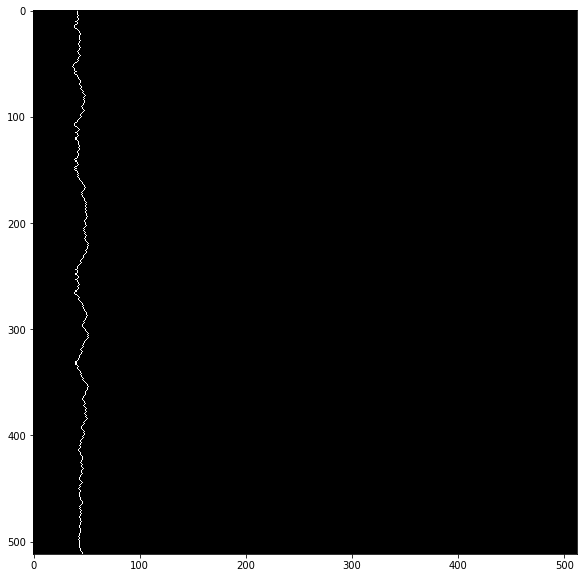

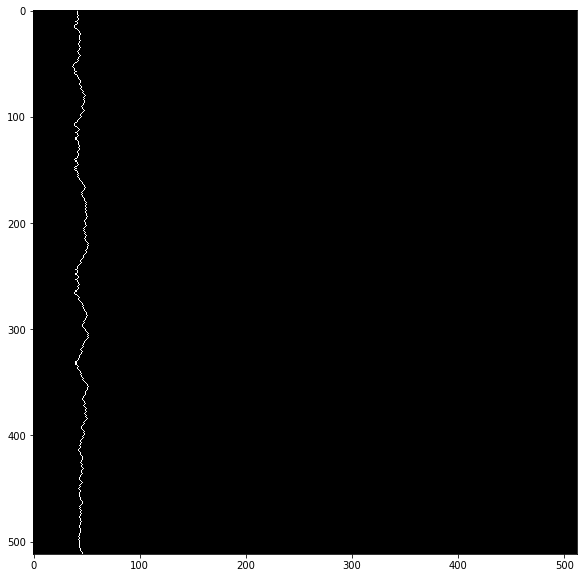

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(mask_true, cmap='gray')
plt.show()